In [1]:
#General Use
import numpy as np
import random
import itertools

#Model Development
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

#Model Analysis / Evaluation
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
# from skimage.io import imshow
import matplotlib.pyplot as plt

#Saving models
import pickle 

In [2]:

local_train_dir = '../../data/images/Training'
image_size = (150, 150)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    local_train_dir, validation_split=0.2, subset="training", seed=1337, image_size=image_size,
    batch_size=32, shuffle=True
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    local_train_dir, validation_split=0.2, subset="validation", seed=1337, image_size=image_size,
    batch_size=32, shuffle=True
    )

Found 31501 files belonging to 2 classes.
Using 25201 files for training.
Found 31501 files belonging to 2 classes.
Using 6300 files for validation.


In [3]:

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [4]:

# InceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Create the base model from the pre-trained model InceptionV3
base_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),    
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 150, 150, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [5]:

METRICS = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.BinaryAccuracy(name='bin_accuracy')
]

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=METRICS)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# Define class weights
total = 0
for image, label in train_ds:
    total += label.numpy().sum()

weight_for_0 = (1 / 1) * (total) / 2.0
weight_for_1 = (1 / 0.5) * (total) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

# Train the model
history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[early_stopping], class_weight=class_weight)

2023-09-03 22:38:50.434681: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25201]
	 [[{{node Placeholder/_4}}]]
2023-09-03 22:38:50.434863: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25201]
	 [[{{node Placeholder/_4}}]]


Epoch 1/20


2023-09-03 22:38:54.316004: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25201]
	 [[{{node Placeholder/_4}}]]
2023-09-03 22:38:54.316194: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25201]
	 [[{{node Placeholder/_4}}]]
/opt/homebrew/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


788/788 [==============================] - ETA: 0s - loss: 244.5067 - auc: 0.9986 - tp: 9075.0000 - tn: 15849.0000 - fp: 154.0000 - fn: 123.0000 - precision: 0.9833 - recall: 0.9866 - bin_accuracy: 0.9890

2023-09-03 22:42:53.500741: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6300]
	 [[{{node Placeholder/_4}}]]
2023-09-03 22:42:53.500940: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6300]
	 [[{{node Placeholder/_0}}]]


788/788 [==============================] - 335s 423ms/step - loss: 244.5067 - auc: 0.9986 - tp: 9075.0000 - tn: 15849.0000 - fp: 154.0000 - fn: 123.0000 - precision: 0.9833 - recall: 0.9866 - bin_accuracy: 0.9890 - val_loss: 0.0135 - val_auc: 0.9995 - val_tp: 2261.0000 - val_tn: 4002.0000 - val_fp: 10.0000 - val_fn: 27.0000 - val_precision: 0.9956 - val_recall: 0.9882 - val_bin_accuracy: 0.9941
Epoch 2/20
788/788 [==============================] - 472s 598ms/step - loss: 57.7152 - auc: 0.9998 - tp: 9168.0000 - tn: 15948.0000 - fp: 55.0000 - fn: 30.0000 - precision: 0.9940 - recall: 0.9967 - bin_accuracy: 0.9966 - val_loss: 0.0079 - val_auc: 0.9995 - val_tp: 2274.0000 - val_tn: 4010.0000 - val_fp: 2.0000 - val_fn: 14.0000 - val_precision: 0.9991 - val_recall: 0.9939 - val_bin_accuracy: 0.9975
Epoch 3/20
788/788 [==============================] - 3146s 4s/step - loss: 38.7179 - auc: 0.9999 - tp: 9180.0000 - tn: 15968.0000 - fp: 35.0000 - fn: 18.0000 - precision: 0.9962 - recall: 0.9980 -

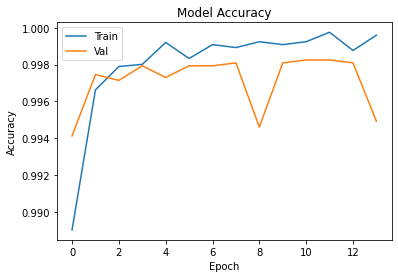

In [14]:
# plotting the accuracy

plt.plot(history.history['bin_accuracy'])
plt.plot(history.history['val_bin_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Training and Validation AUC')

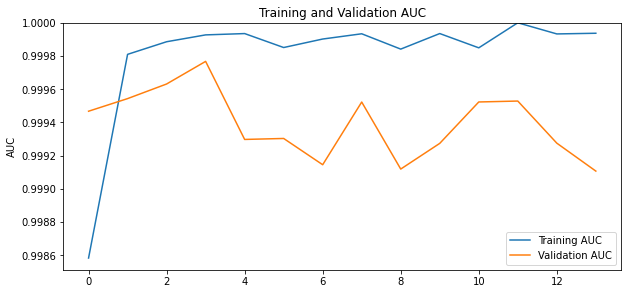

In [11]:

# plotting the metrics
fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.legend(loc='lower right')
plt.ylabel('AUC')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation AUC')


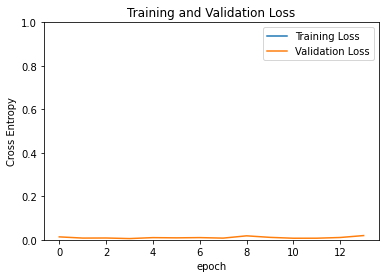

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [7]:

local_test_dir = '../../data/images/Test'

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    local_test_dir, seed=1337, image_size=image_size, batch_size=32, shuffle=True
    )

def test_classification(test_ds, model):
    results_eval = model.evaluate(test_ds, batch_size=32)

    for name, value in zip(model.metrics_names, results_eval):
        print(name, ': ', value)
    print()

    return results_eval

final_model_results = test_classification(test_ds, model)

Found 8617 files belonging to 2 classes.


2023-09-04 01:12:13.042460: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [8617]
	 [[{{node Placeholder/_4}}]]
2023-09-04 01:12:13.042665: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [8617]
	 [[{{node Placeholder/_4}}]]


270/270 [==============================] - 129s 479ms/step - loss: 1.5219 - auc: 0.7054 - tp: 1664.0000 - tn: 4126.0000 - fp: 1011.0000 - fn: 1816.0000 - precision: 0.6221 - recall: 0.4782 - bin_accuracy: 0.6719
loss :  1.521862268447876
auc :  0.705394446849823
tp :  1664.0
tn :  4126.0
fp :  1011.0
fn :  1816.0
precision :  0.6220560669898987
recall :  0.47816091775894165
bin_accuracy :  0.6719275712966919



In [8]:

model.save('InceptionV3_classifier')

INFO:tensorflow:Assets written to: InceptionV3_classifier/assets


INFO:tensorflow:Assets written to: InceptionV3_classifier/assets


197/197 [==============================] - 95s 484ms/step


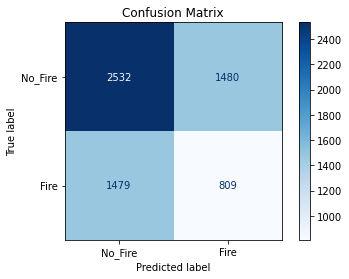

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(val_ds)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Step 4: Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Step 5: Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion, display_labels=['No_Fire', 'Fire'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()